<a href="https://colab.research.google.com/github/iaso1774/appm-4600-numerics/blob/main/Labs/Lab04_AutoDiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Automatic Differentiation

Task:
- in Python using either JAX or PyTorch, define a function that is mathematically equivalent to $f(x)=x$ yet its AutoDiff "derivative" is
$$f'(x)=\begin{cases} 1 & x \neq 0 \\ -17 & x=0\end{cases}$$

**Deliverables**

In your PDF you upload to Canvas, show relevant parts of your code, and a plot of the AutoDiff "derivative" that clearly shows $f'(0)=-17$ and $f'(x)=1$ for $x\neq 0$.

Learning objectives
- Learn the basics of using AutoDiff in either PyTorch or JAX
- Understand that the AutoDiff "derivative" need not be the same as its "usual" derivative.

Copyright 2025, Department of Applied Mathematics, University of Colorado Boulder. Released under the BSD 3-Clause License

Note: unlike some of the other demos, for this demo, we *encourage* you to use Colab, since Colab has the main autodiff packages pre-installed (jax and PyTorch)

If you want more of this lab, see [SciML: Lab 4](https://github.com/cu-applied-math/SciML-Class/blob/main/Labs/lab04.md) and its [SciML: Lab 4 solutions](https://github.com/cu-applied-math/SciML-Class/blob/lab_solutions/Labs/lab04_AD.ipynb) which adds a few tasks

This lab is inspired by the paper [A mathematical model for automatic differentiation in machine learning](https://hal.science/hal-02734446/file/finalVersion.pdf) by Jérôme Bolte and Edouard Pauwels, NeurIPS 2020

PyTorch has info on [Autograd mechanics](https://pytorch.org/docs/stable/notes/autograd.html), including:

- [Gradients for non-differentiable functions](https://pytorch.org/docs/stable/notes/autograd.html#gradients-for-non-differentiable-functions)

## If you want to use JAX...

Below is an example of how to use JAX's AutoDiff

In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from matplotlib import pyplot as plt
import numpy as np

JAX cannot handle a pure "if" statement. You need to use their builtin [`jax.lax.cond`](https://docs.jax.dev/en/latest/_autosummary/jax.lax.cond.html). Below is an example of how to use it. We'll implement the function
$$f(x)=\begin{cases} \cos(12x) & x\ge 0 \\ 0 & x < 0\end{cases}$$

In [2]:
def f(x):
  return jax.lax.cond( x>=0, lambda : jnp.cos(12*x), lambda : 0.)
  # return jax.lax.cond( x>=0, lambda : jnp.cos(12*x), lambda : 0) # fails, since type(0)=int not float

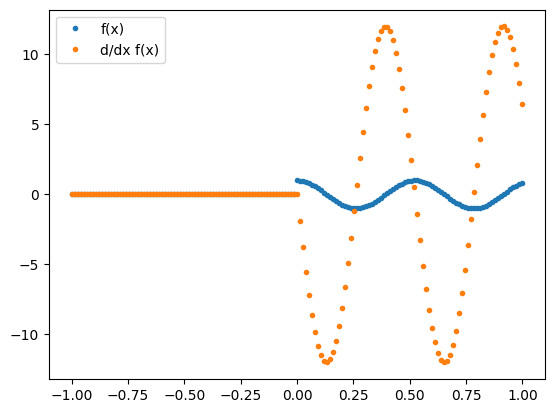

In [3]:
xGrid = np.linspace(-1,1,151)
x = jnp.array(xGrid)

# plt.plot(x,f(x)) # this won't work because f(x) expects a scalar input...

f_vectorized = vmap(f) # ... so do this instead

plt.plot( x, f_vectorized(x),'.', label='f(x)' )
fprime = vmap(grad(f))
plt.plot(x,fprime(x),'.',label='d/dx f(x)')
plt.legend()
plt.show()

## If you want to use PyTorch...

In [4]:
import torch
from matplotlib import pyplot as plt
import numpy as np

Below is an example of how to use it. We'll implement the function
$$f(x)=\begin{cases} \cos(12x) & x\ge 0 \\ 0 & x < 0\end{cases}$$

In [5]:
def f(x):
  return torch.where( x >= 0, torch.cos(12*x), 0.) # if we want to use torch.vmap
  # if x >= 0:
  #   return torch.cos(12*x)
  # else:
  #   # return 0. # doens't work
  #   return 0*x

In [6]:
# Instead of using torch.vmap, we can do it by hand
def find_derivative(fcn,xGrid):
    """ returns the derivative of fcn evaluated at xGrid """
    x      = torch.zeros(1, requires_grad = True)
    deriv = torch.zeros_like(xGrid)
    for i,xval in enumerate(xGrid):
        x.data = xval
        fx = fcn(x)
        fx.backward()
        deriv[i] = x.grad.data
        x.grad.data.zero_()
    return deriv

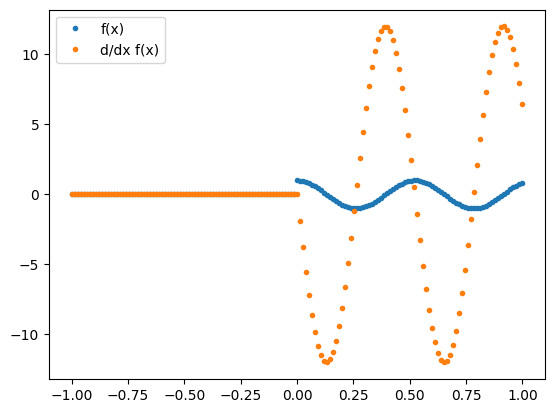

In [7]:
xGrid = np.linspace(-1,1,151)
x = torch.tensor(xGrid)
df = find_derivative(f,x)
plt.plot(x,torch.vmap(f)(x),'.',label='f(x)')
plt.plot(x,df,'.',label='d/dx f(x)')
plt.legend()
plt.show()

In [8]:
@jax.custom_jvp
def f(x):
    return x

@f.defjvp
def f_jvp(primals, tangents):
    x, = primals
    xdot, = tangents
    primal_out = f(x)
    tangent_out = jnp.where(x == 0.0, -17.0, 1.0) * xdot
    return primal_out, tangent_out

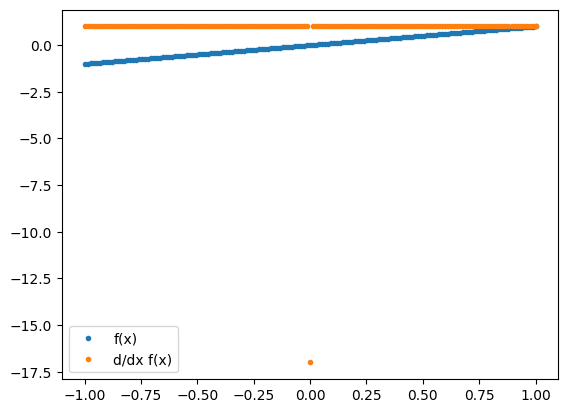

In [9]:
xGrid = np.linspace(-1,1,151)
x = jnp.array(xGrid)

f_vectorized = vmap(f)

plt.plot( x, f_vectorized(x),'.', label='f(x)' )
fprime = vmap(grad(f))
plt.plot(x,fprime(x),'.',label='d/dx f(x)')
plt.legend()
plt.show()